Пришло время проанализировать результаты эксперимента. Эксперимент проходил с 2023-01-31 по 2023-02-06 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Задача — проанализировать данные АB-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandahouse as ph
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
# Расчет CTR в группах 2 и 3 за период с 24 по 30 января

q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df = ph.read_clickhouse(q, connection=connection)

In [4]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


# T-тест

In [5]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
df[df.exp_group == 2].ctr,
equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

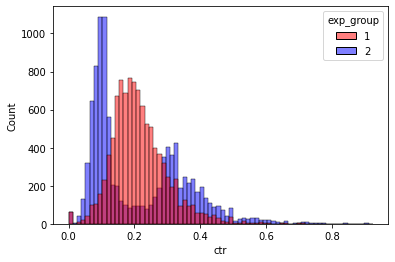

In [6]:
groups = sns.histplot(data = df,
x='ctr',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

p-value больше 0,05, что свидетельствует об отсутствии стат.значимых различий между группами.
Однако по графику видно, что различия есть. При этом, значения в тестовой группе распределились ненормально. Кажется, что у одной части пользователей с новым алгоритмом CTR повысился, а у другой части - стал меньше 


# Тест Манна-Уитни

In [7]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
df[df.exp_group == 2].ctr,
alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Согласно, тесту Манна Уитни, имеются стат.значимые различия, тк значения p-value очень маленькое. Это неудивительно, ведь распределения в 1 и 2 группах сильно отличаются

# T-тест на сглаженном ctr (α=5)

In [8]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [9]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

<AxesSubplot:xlabel='ctr', ylabel='Count'>

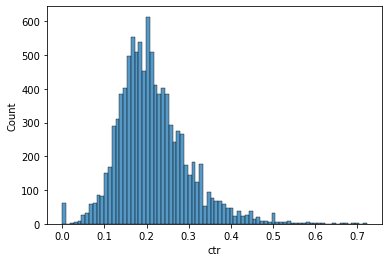

In [11]:
group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr, kde = False)

In [12]:
group1['smothed_ctr'] = df.apply(
lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

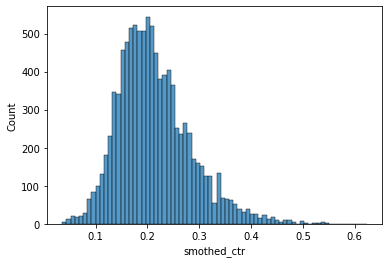

In [13]:
sns.histplot(group1.smothed_ctr, kde = False)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

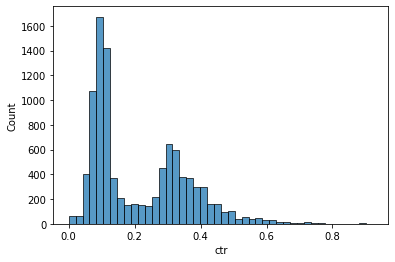

In [14]:
group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.ctr, kde = False)

In [15]:
group2['smothed_ctr'] = df.apply(
lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

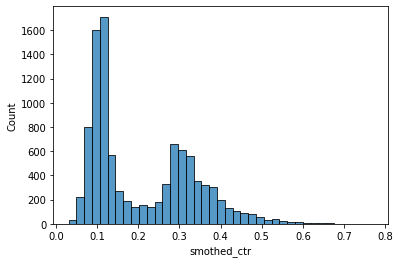

In [16]:
# Сглаживание не сильно помогло, распределение CTR в тестовой группе ненормальное и бимодальное
sns.histplot(group2.smothed_ctr, kde = False)

In [17]:
stats.ttest_ind(group1.smothed_ctr,
group2.smothed_ctr,
equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

T-тест на сглаженном ctr показал, что стат.значимые различия между группами имеются (p-value < 0,05)

# Пуассоновский бутстреп

In [22]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [23]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [25]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

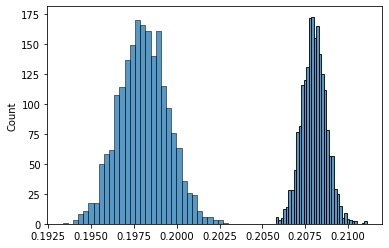

In [26]:
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

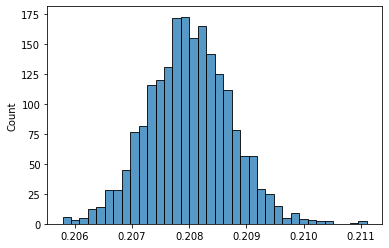

In [27]:
sns.histplot(ctr1)

<AxesSubplot:ylabel='Count'>

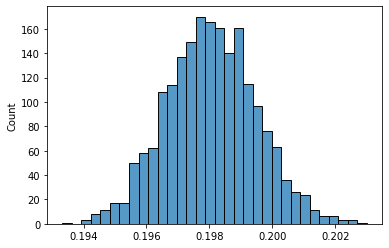

In [28]:
sns.histplot(ctr2)

Судя по графикам, групповой CTR в контрольной группе выше, чем в тестовой

<AxesSubplot:ylabel='Count'>

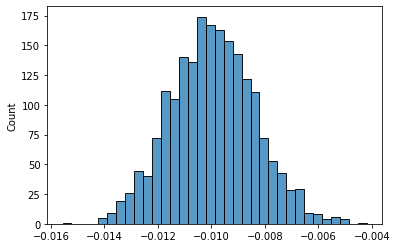

In [29]:
#Разница между глобальными CTR
sns.histplot(ctr2 - ctr1)

Гистограмма разности между глобальными CTR не пересекает 0, значит, одна группа строго больше другой. И так как при вычитании из CTR тестовой группы CTR контрольной значения меньше нуля, можно утверждать, что в тестовой группе CTR оказался меньше

# Т-тест поверх бакетного преобразования

In [30]:
q = """
SELECT exp_group, bucket,
sum(likes)/sum(views) as bucket_ctr,
quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group,
xxHash64(user_id)%50 as bucket,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
and exp_group in (1,2)
GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df_1 = ph.read_clickhouse(q, connection=connection)

Распределение CTR внутри бакетов

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

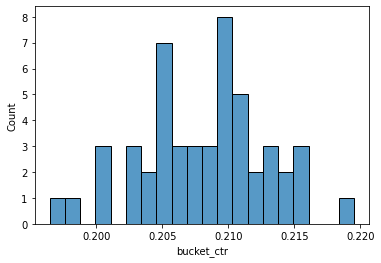

In [31]:
sns.histplot(df_1[df_1.exp_group == 1].bucket_ctr, bins=20)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

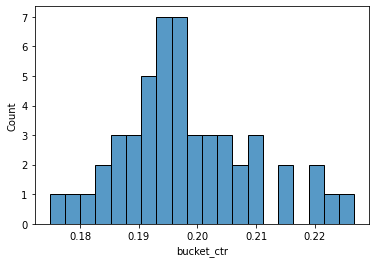

In [32]:
sns.histplot(df_1[df_1.exp_group == 2].bucket_ctr, bins=20)

Распределение CTR в бакетах 1 группы не похоже на нормальное, в бакетах 2 группы +- похоже

# Т-тест поверх бакетного преобразования

In [33]:
stats.ttest_ind(df_1[df_1.exp_group == 1].bucket_ctr,
df_1[df_1.exp_group == 2].bucket_ctr,
equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

# Тест Манна-Уитни поверх бакетного преобразования

In [34]:
stats.mannwhitneyu(df_1[df_1.exp_group == 1].bucket_ctr,
df_1[df_1.exp_group == 2].bucket_ctr,
alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Как Т-тест, так и тест Манна-Уитни показали наличие стат.значимых различий в CTR

# Распределения квантилей:

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

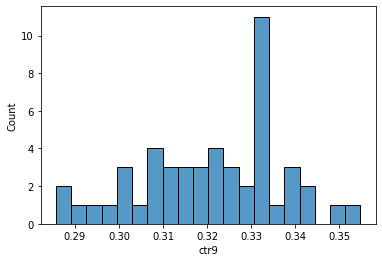

In [35]:
sns.histplot(df_1[df_1.exp_group == 1].ctr9, bins=20)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

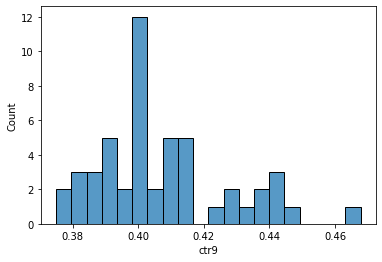

In [36]:
sns.histplot(df_1[df_1.exp_group == 2].ctr9, bins=20)

In [37]:
stats.mannwhitneyu(df_1[df_1.exp_group == 1].ctr9,
df_1[df_1.exp_group == 2].ctr9,
alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.344839189967265e-18)

Отличия в 90% квантилях в группах 1 и 2 имеются

Рекомендуется не раскатывать новый алгоритм на всех новых пользователей. Практически все тесты (за исключением первого т-теста) показали p-value < 0,05. Однако как следует из первого графика распределения CTR, часть пользователей из тестовой группы показала CTR лучше, а часть - хуже по сравнению с контрольной группой. А согласно графику разности между глобальными CTR, в тестовой группе CTR оказался меньше.   

Возможно, новый алгоритм повышает CTR какой-то группы пользователей, объединенной общим призаком. 
Следует изучить, по какому признаку разделились пользователи в тестовой группе, из-за чего распределение CTR стало бимодальным.